In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install scikit-learn
# !pip install category-encoders
# !pip install imbalanced-learn
# !pip install lightgbm
# !pip install xgboost

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from category_encoders import CountEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline

In [8]:
df = pd.read_csv('data/transactions.csv')

In [10]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [11]:
df.rename(columns = {'Account':'Sender Account', 'Account.1':'Receiver Account'}, inplace = True) 

In [12]:
df.head(2)

,Timestamp,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0


## Data Analysis

In [13]:
df.shape

(5078345, 11)

In [14]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,4.573057e+04,6.574456e+04,5.988726e+06,4.509273e+06,1.019427e-03
std,8.176562e+04,8.409299e+04,1.037183e+09,8.697728e+08,3.191219e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411010e+03,1.414540e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234627e+04,1.229784e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [15]:
df.describe(include=object)

,Timestamp,Sender Account,Receiver Account,Receiving Currency,Payment Currency,Payment Format
count,5078345,5078345,5078345,5078345,5078345,5078345
unique,15018,496995,420636,15,15,7
top,2022/09/01 00:04,100428660,100428660,US Dollar,US Dollar,Cheque
freq,11193,168672,1084,1879341,1895172,1864331


In [16]:
df.isnull().sum()

Timestamp             0
From Bank             0
Sender Account        0
To Bank               0
Receiver Account      0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [17]:
df[df.duplicated()==True]

,Timestamp,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
863295,2022/09/01 16:20,12004,800C927C1,12004,800C927C0,0.000008,Bitcoin,0.080000,Euro,ACH,0
863296,2022/09/01 16:20,12004,800C927C1,220,813D8C1E1,0.000008,Bitcoin,0.000008,Bitcoin,Bitcoin,0
3684005,2022/09/07 21:25,29992,8099A29B1,220,813725AE1,0.000003,Bitcoin,0.000003,Bitcoin,Bitcoin,0
4166786,2022/09/08 21:05,113779,811144AB1,113779,811144AB0,0.000002,Bitcoin,0.020000,US Dollar,ACH,0
4166787,2022/09/08 21:05,113779,811144AB1,53744,813C777F1,0.000002,Bitcoin,0.000002,Bitcoin,Bitcoin,0
4510480,2022/09/09 10:03,6075,80C702911,6075,80C702910,0.000002,Bitcoin,0.020000,US Dollar,ACH,0
4510481,2022/09/09 10:03,6075,80C702911,154653,814389B61,0.000002,Bitcoin,0.000002,Bitcoin,Bitcoin,0
4816512,2022/09/09 21:33,14433,80935A891,14433,80935A890,0.000001,Bitcoin,0.010000,US Dollar,ACH,0
4816513,2022/09/09 21:33,14433,80935A891,15,813F7AE61,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0


In [18]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [20]:
df.shape

(5078336, 11)

## Creating features from 'Timestamp' column

In [21]:
df.Timestamp.head()

0    2022/09/01 00:20
1    2022/09/01 00:20
2    2022/09/01 00:00
3    2022/09/01 00:02
4    2022/09/01 00:06
Name: Timestamp, dtype: object

In [22]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M')

In [23]:
df.dtypes

Timestamp             datetime64[ns]
From Bank                      int64
Sender Account                object
To Bank                        int64
Receiver Account              object
Amount Received              float64
Receiving Currency            object
Amount Paid                  float64
Payment Currency              object
Payment Format                object
Is Laundering                  int64
dtype: object

In [24]:
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute

In [25]:
df['Year'].nunique()

1

In [26]:
df['Month'].nunique()

1

In [27]:
df['Day'].nunique()

18

In [28]:
df['Hour'].nunique()

24

In [29]:
df['Minute'].nunique()

60

In [30]:
df.drop(columns=['Year', 'Month', 'Timestamp'], inplace=True)

In [31]:
df.head()

,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Day,Hour,Minute
0,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,1,0,20
1,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,1,0,20
2,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,1,0,0
3,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,1,0,2
4,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,1,0,6


## Checking the distribution of target variable

In [32]:
df['Is Laundering'].value_counts()

Is Laundering
0    5073159
1       5177
Name: count, dtype: int64

In [34]:
print('No Money Laundering:', round(df['Is Laundering'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Money Laundering:', round(df['Is Laundering'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Money Laundering: 99.9 % of the dataset
Money Laundering: 0.1 % of the dataset


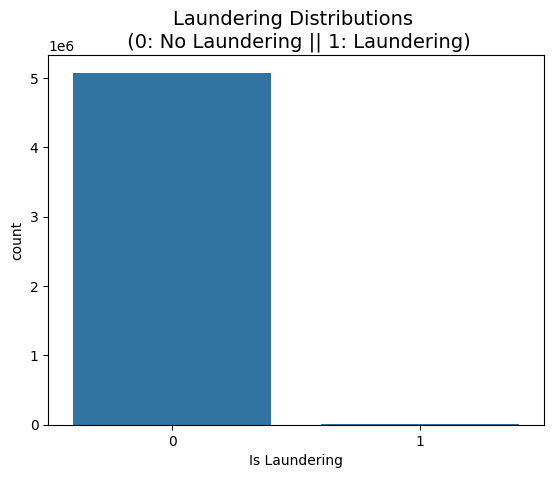

In [35]:
sns.countplot(x='Is Laundering', data=df)
plt.title('Laundering Distributions \n (0: No Laundering || 1: Laundering)', fontsize=14)
plt.show()

## Analysis of categorical variables

In [36]:
df.select_dtypes(include=['object']).columns

Index(['Sender Account', 'Receiver Account', 'Receiving Currency',
       'Payment Currency', 'Payment Format'],
      dtype='object')

In [37]:
# Create a contingency table
def create_contingency_table(col_1, col_2):
    contingency_table = pd.crosstab(df[col_1], df[col_2])
    
    # Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    return p_value
    
print(f"P-value Sender Account: {create_contingency_table('Sender Account', 'Is Laundering')}")
print(f"P-value Receiver Account: {create_contingency_table('Receiver Account', 'Is Laundering')}")
print(f"P-value Receiving Currency: {create_contingency_table('Receiving Currency', 'Is Laundering')}")
print(f"P-value Payment Currency: {create_contingency_table('Payment Currency', 'Is Laundering')}")
print(f"P-value Payment Format: {create_contingency_table('Payment Format', 'Is Laundering')}")

P-value Sender Account: 0.0
P-value Receiver Account: 0.0
P-value Receiving Currency: 4.689388091722716e-217
P-value Payment Currency: 2.0941379172816512e-219
P-value Payment Format: 0.0


In [ ]:
df['Receiving Currency'].value_counts()

Receiving Currency
US Dollar            1879341
Euro                 1172017
Swiss Franc           237884
Yuan                  206551
Shekel                194988
Rupee                 192065
UK Pound              181255
Ruble                 157361
Yen                   156319
Bitcoin               148142
Canadian Dollar       141357
Australian Dollar     138511
Mexican Peso          111030
Saudi Riyal            89971
Brazil Real            71544
Name: count, dtype: int64

In [ ]:
df['Payment Currency'].value_counts()

Payment Currency
US Dollar            1895169
Euro                 1168296
Swiss Franc           234860
Yuan                  213752
Shekel                192184
Rupee                 190202
UK Pound              180738
Yen                   155209
Ruble                 155178
Bitcoin               146061
Canadian Dollar       140042
Australian Dollar     136769
Mexican Peso          110159
Saudi Riyal            89014
Brazil Real            70703
Name: count, dtype: int64

In [ ]:
df['Payment Format'].value_counts()

Payment Format
Cheque          1864331
Credit Card     1323324
ACH              600793
Cash             490891
Reinvestment     481056
Wire             171855
Bitcoin          146086
Name: count, dtype: int64

In [ ]:
df['Sender Account'].value_counts()

Sender Account
100428660    168672
1004286A8    103018
100428978     20497
1004286F0     18663
100428780     17264
              ...  
806198930         1
806197550         1
80127BE50         1
8061935F0         1
8148A8671         1
Name: count, Length: 496995, dtype: int64

In [ ]:
df['Receiver Account'].value_counts()

Receiver Account
100428660    1084
1004286A8     653
80F47A310     159
100428978     150
8018859B0     144
             ... 
80B14E9D0       1
80B159D00       1
812577710       1
812569750       1
80F91C540       1
Name: count, Length: 420636, dtype: int64

In [38]:
df[df['Is Laundering']==1]

,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Day,Hour,Minute
4742,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1,1,0,21
40621,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1,1,0,3
69152,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,1,1,0,1
85763,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1,1,0,3
90684,70,100428660,32375,80E480620,14288.83,US Dollar,14288.83,US Dollar,Cash,1,1,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5071159,111433,8065C2380,21550,8065C69E0,7773.42,US Dollar,7773.42,US Dollar,ACH,1,10,23,29
5073366,9,80727F930,219557,8072A28C0,448920.65,Ruble,448920.65,Ruble,Cheque,1,10,23,7
5074239,222,812D127D0,50202,812D129C0,20085.71,Saudi Riyal,20085.71,Saudi Riyal,ACH,1,12,3,34
5075047,17327,8095F6C20,15695,8095F6C70,3314.36,US Dollar,3314.36,US Dollar,ACH,1,10,23,43


In [40]:
# laundering_senders
df[df['Is Laundering'] == 1]['Sender Account'].value_counts()

Sender Account
100428660    243
1004286A8    158
100428978     29
80266F880     29
100428810     26
            ... 
80AAB0290      1
80C7075C0      1
801BCE220      1
80E35A3D0      1
804FAA470      1
Name: count, Length: 3376, dtype: int64

In [41]:
# laundering_receivers
df[df['Is Laundering'] == 1]['Receiver Account'].value_counts()

Receiver Account
811C599A0    31
8021353D0    28
811C597B0    23
80266F880    22
811ED7DF0    20
             ..
80CE42970     1
812D8B310     1
804EDE8F0     1
80DB5D190     1
804FAD580     1
Name: count, Length: 3984, dtype: int64

In [42]:
# laundering received currency
df[df['Is Laundering']==1]['Receiving Currency'].value_counts()

Receiving Currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

In [43]:
# laundering sent payment currency
df[df['Is Laundering']==1]['Payment Currency'].value_counts()

Payment Currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64

In [44]:
# laundering payment format
df[df['Is Laundering']==1]['Payment Format'].value_counts()

Payment Format
ACH            4483
Cheque          324
Credit Card     206
Cash            108
Bitcoin          56
Name: count, dtype: int64

## Analysis of numeric variables

In [45]:
df[df.select_dtypes(include='number').columns].corr()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering,Day,Hour,Minute
From Bank,1.000000,0.289930,-0.000909,-0.000442,-0.000230,-0.063675,-0.044674,-0.024971
To Bank,0.289930,1.000000,-0.000523,0.000406,-0.005723,-0.020700,-0.010669,-0.005096
Amount Received,-0.000909,-0.000523,1.000000,0.843147,0.000929,-0.001124,0.000281,0.001140
Amount Paid,-0.000442,0.000406,0.843147,1.000000,0.001162,-0.001107,0.000056,0.000724
Is Laundering,-0.000230,-0.005723,0.000929,0.001162,1.000000,0.018885,0.005488,0.002061
Day,-0.063675,-0.020700,-0.001124,-0.001107,0.018885,1.000000,0.103235,0.058341
Hour,-0.044674,-0.010669,0.000281,0.000056,0.005488,0.103235,1.000000,0.107665
Minute,-0.024971,-0.005096,0.001140,0.000724,0.002061,0.058341,0.107665,1.000000


In [46]:
df['From Bank'].value_counts()

From Bank
70        449859
10         81629
12         79754
1          62211
15         52511
           ...  
351005         1
351022         1
349350         1
340466         1
336827         1
Name: count, Length: 30470, dtype: int64

In [47]:
df['To Bank'].value_counts()

To Bank
10        42547
12        41872
15        38720
220       30623
1         30115
          ...  
355235        1
314154        1
319451        1
337181        1
352782        1
Name: count, Length: 15811, dtype: int64

In [48]:
df['Amount Paid'].value_counts()

Amount Paid
1.000000e-02    4562
2.000000e-02    1771
3.000000e-02    1146
4.000000e-02     795
5.000000e-02     611
                ... 
2.607345e+04       1
3.011200e+05       1
1.768681e+06       1
2.042131e+06       1
2.819830e-01       1
Name: count, Length: 923873, dtype: int64

In [49]:
df['Amount Received'].value_counts()

Amount Received
0.010000         4368
0.020000         1574
0.030000         1074
0.040000          735
0.000001          625
                 ... 
374868.900000       1
67193.580000        1
36965.360000        1
18435.110000        1
0.281983            1
Name: count, Length: 915161, dtype: int64

In [50]:
df['Day'].value_counts()

Day
1     1114919
2      754449
9      654463
8      482771
7      482750
5      482650
6      482089
10     208325
4      207430
3      207382
11        396
12        281
13        184
14        121
15         46
16         46
17         23
18         11
Name: count, dtype: int64

In [51]:
df['Hour'].value_counts()

Hour
0     634726
15    194871
6     194456
5     193900
1     193728
11    193500
16    193405
23    193345
7     193336
18    193321
3     193249
10    193227
4     193166
17    193154
2     193143
12    192972
9     192952
8     192921
19    192824
20    192809
14    192787
13    192521
21    192187
22    191836
Name: count, dtype: int64

In [52]:
df['Minute'].value_counts()

Minute
4     92693
7     92649
23    92567
21    92421
26    92333
5     92332
28    92312
24    92191
14    92184
17    92150
6     92106
27    92089
3     92044
16    92017
1     92003
18    91961
8     91943
29    91912
22    91896
13    91893
10    91874
0     91857
20    91820
25    91819
9     91814
2     91746
19    91660
12    91465
15    91318
11    91094
35    78195
57    77830
40    77651
30    77576
58    77553
46    77482
34    77472
59    77464
38    77459
54    77389
53    77359
41    77341
48    77323
49    77286
39    77229
56    77186
55    77180
51    77166
45    77165
52    77163
42    77084
32    77075
36    77072
31    77061
47    77051
50    76979
37    76917
43    76895
44    76869
33    76701
Name: count, dtype: int64

## Train Test Split

In [53]:
df.shape

(5078336, 13)

In [54]:
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

In [55]:
X.head()

,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Day,Hour,Minute
0,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,1,0,20
1,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,1,0,20
2,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,1,0,0
3,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,1,0,2
4,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,1,0,6


In [56]:
y.value_counts()

Is Laundering
0    5073159
1       5177
Name: count, dtype: int64

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [62]:
X_train

,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Day,Hour,Minute
4891123,5627,8030205D0,29191,81156ED40,8096.00,Yuan,8096.00,Yuan,Credit Card,10,0,51
4301880,20,80017C540,12,80017DAD0,176.57,Euro,176.57,Euro,Credit Card,9,2,39
2335358,9417,80370D660,232304,80E8A59F0,22570.98,Yuan,22570.98,Yuan,Cheque,5,1,38
226981,6,804D528C0,112931,805252600,71605.14,Rupee,71605.14,Rupee,Credit Card,1,0,8
706937,15,8039E31B0,210319,803CC8270,35757.33,Yen,35757.33,Yen,Cash,1,11,30
...,...,...,...,...,...,...,...,...,...,...,...,...
4638536,1267,802169B20,112078,80B144970,99544.65,Yuan,99544.65,Yuan,Cheque,9,15,14
985020,221691,80B81EF30,24161,80C6C8020,1456.44,US Dollar,1456.44,US Dollar,Credit Card,1,20,18
4312730,14077,803791080,115700,80ACD9A70,172.98,US Dollar,172.98,US Dollar,ACH,9,3,29
3121734,24856,809867800,24779,809E57DD0,1909.03,Canadian Dollar,1909.03,Canadian Dollar,Credit Card,6,17,15


In [63]:
y_train.value_counts()

Is Laundering
0    3399016
1       3469
Name: count, dtype: int64

In [64]:
X_test

,From Bank,Sender Account,To Bank,Receiver Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Day,Hour,Minute
1753554,1501,802097E60,16418,8028BE1E0,12891.48,Euro,12891.48,Euro,Credit Card,2,20,23
3146155,125906,80D03F980,29003,80F337AA0,44.21,US Dollar,44.21,US Dollar,Cheque,6,18,59
1364530,1412,80177CCF0,214621,80668D4C0,4.28,US Dollar,4.28,US Dollar,Cheque,2,7,35
4803826,3435,800F39270,22164,800F39220,123.79,US Dollar,123.79,US Dollar,Cash,9,21,36
4083324,23344,80212BDC0,24850,802056870,1272.61,Euro,1272.61,Euro,Cheque,8,17,24
...,...,...,...,...,...,...,...,...,...,...,...,...
3112624,29,80CE3CBF0,10,80D5A6690,2445.05,Brazil Real,2445.05,Brazil Real,Cheque,6,16,34
147352,26818,804EC38B0,26818,804EC38B0,6.09,Euro,6.09,Euro,Reinvestment,1,0,0
2424474,16678,806182820,16678,806B385F0,4373.72,Ruble,4373.72,Ruble,Credit Card,5,6,18
896565,153502,813C754B1,15,813C76761,2.00,Bitcoin,2.00,Bitcoin,Bitcoin,1,17,14


In [65]:
y_test.value_counts()

Is Laundering
0    1674143
1       1708
Name: count, dtype: int64

## Data Preprocessing

In [66]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()

In [67]:
account_features = ['Sender Account', 'Receiver Account']
payment_features = ['Receiving Currency', 'Payment Currency', 'Payment Format']

In [68]:
print('Numeric Features:', numeric_features, '\nAccount Related Features:', account_features, '\nPayment Related Features:', payment_features, sep='\n')

Numeric Features:
['From Bank', 'To Bank', 'Amount Received', 'Amount Paid', 'Day', 'Hour', 'Minute']

Account Related Features:
['Sender Account', 'Receiver Account']

Payment Related Features:
['Receiving Currency', 'Payment Currency', 'Payment Format']


In [72]:
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
        
])


cat_pipeline_1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('count_encoder', CountEncoder())
])


cat_pipeline_2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoder())
])

In [73]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, numeric_features),
        ('cat_pipeline_1', cat_pipeline_1, account_features),
        ('cat_pipeline_2', cat_pipeline_2, payment_features),
])

In [74]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [77]:
y_train.value_counts()

Is Laundering
0    3399016
1       3469
Name: count, dtype: int64

## Handling Imbalanced Dataset

In [78]:
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

In [79]:
X_train_smote.shape

(6798032, 46)

In [80]:
y_train_smote.shape

(6798032,)

In [90]:
y_train_smote.value_counts()

Is Laundering
0    3399016
1    3399016
Name: count, dtype: int64

## Model Training and Evaluation

In [92]:
# Evaluate Model
def evaluate_model(true, predicted):
    conf_matrix = confusion_matrix(true, predicted)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    f1_src = f1_score(true, predicted)
    return conf_matrix, accuracy, precision, recall, f1_src

models = {
    "Logistic Regression": LogisticRegression(n_jobs=6),
    "DecisionTree Classifier": DecisionTreeClassifier(max_depth=10),
    "RandomForest Classifier": RandomForestClassifier(n_jobs=6, max_depth=10),
    "NaiveBayes Classifier": BernoulliNB(),
    # "LGBM Classifier": LGBMClassifier(n_estimators=200, n_jobs=6, max_depth=10, num_leaves=1023),
    # "XGB Classifier": XGBClassifier(n_estimators=200, n_jobs=6, max_depth=10),
}

model_list = []
recall_list = []

for i in range(len(list(models))):
    
    print(list(models.keys())[i])
    model = list(models.values())[i]
    model.fit(X_train_smote, y_train_smote) # Train model

    # Make predictions
    y_pred = model.predict(X_test_transformed)
    
    # Evaluate Test dataset
    conf_matrix, accuracy, precision, recall, f1_src = evaluate_model(y_test, y_pred)
    
    # Update Model list
    model_list.append(list(models.keys())[i])
    
    # Update Recall list
    recall_list.append(recall)

    # Display results
    print('Model performance for Test set')
    print("- Confusion Matrix:\n{}".format(conf_matrix))
    print("- Accuracy: {:.4f}".format(accuracy))
    print("- Precision: {:.4f}".format(precision))
    print("- Recall: {:.4f}".format(recall))
    print("- F1-Score: {:.4f}".format(f1_src))

    print('='*40)
    print('\n')

Logistic Regression
Model performance for Test set
- Confusion Matrix:
[[1413940  260203]
 [    134    1574]]
- Accuracy: 0.8447
- Precision: 0.0060
- Recall: 0.9215
- F1-Score: 0.0119


DecisionTree Classifier
Model performance for Test set
- Confusion Matrix:
[[1528003  146140]
 [    301    1407]]
- Accuracy: 0.9126
- Precision: 0.0095
- Recall: 0.8238
- F1-Score: 0.0189


RandomForest Classifier
Model performance for Test set
- Confusion Matrix:
[[1546494  127649]
 [    263    1445]]
- Accuracy: 0.9237
- Precision: 0.0112
- Recall: 0.8460
- F1-Score: 0.0221


NaiveBayes Classifier
Model performance for Test set
- Confusion Matrix:
[[1468020  206123]
 [    214    1494]]
- Accuracy: 0.8769
- Precision: 0.0072
- Recall: 0.8747
- F1-Score: 0.0143




In [ ]:
pd.DataFrame(list(zip(model_list, recall_list)), columns=['Model Name', 'Recall Score']).sort_values(by=["Recall Score"],ascending=False)